In [1]:
node_num = 16
latent_num = 16
suffix = '_16node_16latent_1step'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2023-11-14 13:27:02.342739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 13:27:02.405507: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Parameter data

In [4]:
import numpy as np
import os

training_id = 0
check_point = 350
end_point = 400

folder_path = os.path.join(os.getcwd(), '../learn_output')
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))

weight = np.load(file_path, allow_pickle=True)

x_train_para = weight[:-1,:]
y_train_para = weight[1:,:]

for training_id in range(1, check_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_train_para = np.concatenate((x_train_para, weight[:-1,:]), axis = 0)
    y_train_para = np.concatenate((y_train_para, weight[1:,:]), axis = 0)

training_id = check_point
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
weight = np.load(file_path, allow_pickle=True)

x_test_para = weight[:-1,:]
y_test_para = weight[1:,:]

for training_id in range(check_point + 1, end_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_test_para = np.concatenate((x_test_para, weight[:-1,:]), axis = 0)
    y_test_para = np.concatenate((y_test_para, weight[1:,:]), axis = 0)

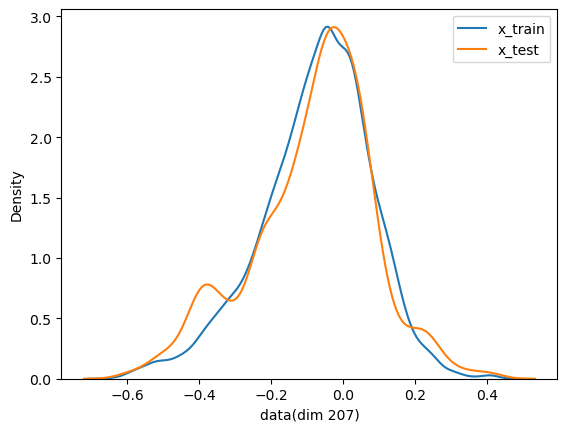

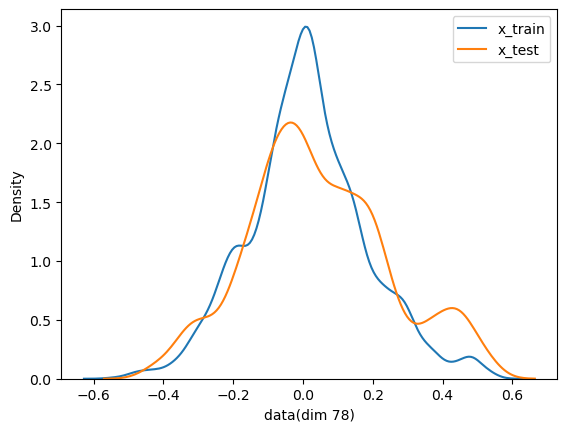

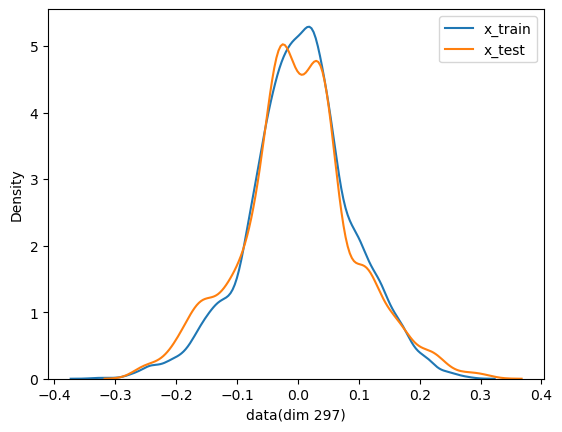

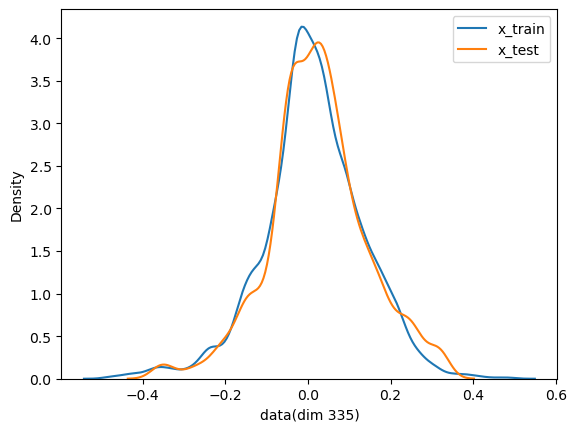

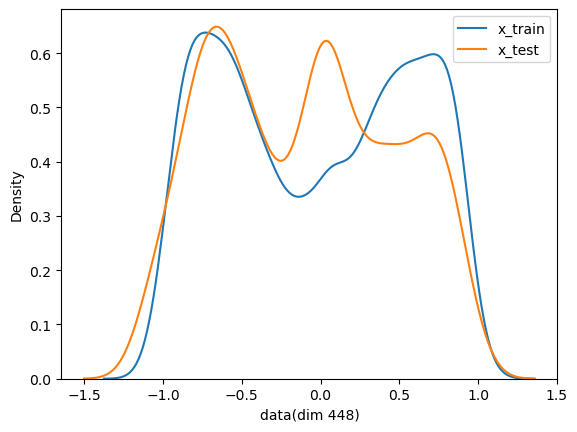

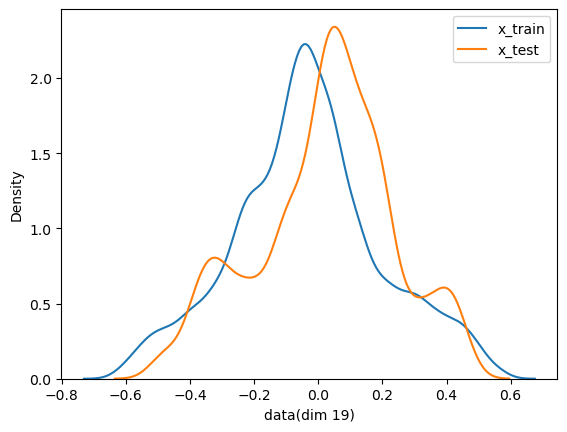

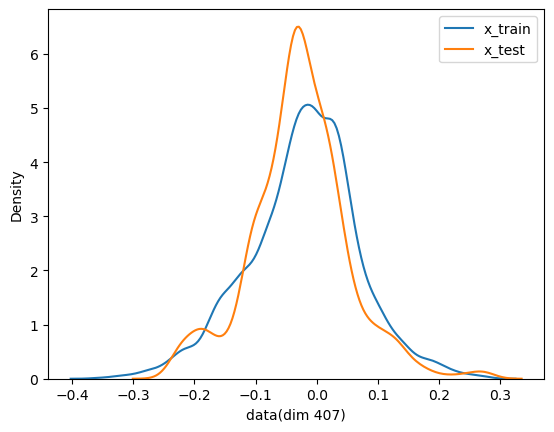

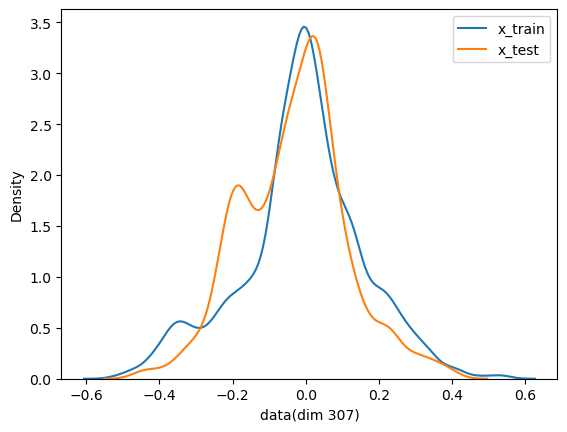

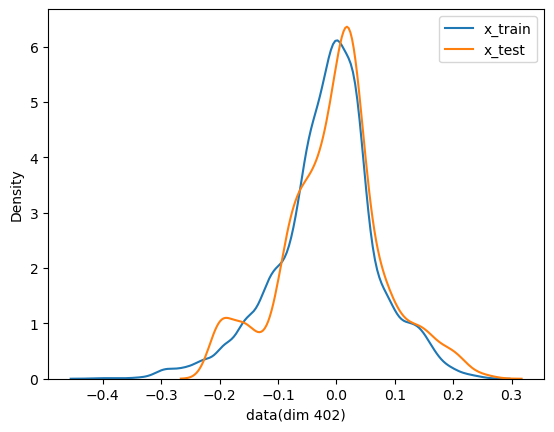

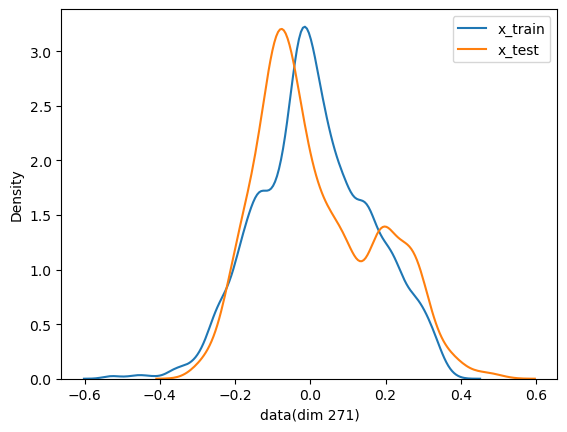

[207, 78, 297, 335, 448, 19, 407, 307, 402, 271]


In [5]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train_para[:, random_number], label = 'x_train')
    sns.kdeplot(x_test_para[:, random_number], label = 'x_test')
    plt.xlabel('data(dim %d)' % random_number)
    plt.legend()
    plt.show()

print(random_numbers)

In [6]:
permuted_indices = np.random.permutation(x_train_para.shape[0])
x_train_para = x_train_para[permuted_indices, :]
y_train_para = y_train_para[permuted_indices, :]

In [7]:
from tensorflow import keras

inputs = keras.Input(shape=(26,), name="digits")
x = keras.layers.Dense(node_num, activation="relu", kernel_initializer="uniform",bias_initializer="uniform")(inputs)
outputs = keras.layers.Dense(2, name="predictions",kernel_initializer="uniform",bias_initializer="uniform")(x)
model_mnist = keras.Model(inputs=inputs, outputs=outputs, name = 'model_mnist')

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Compile the model
model_mnist.compile(optimizer=optimizer, loss=loss_fn,  metrics=["accuracy"])

2023-11-14 13:27:08.910095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 13:27:09.375398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22101 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c3:00.0, compute capability: 8.6


## Mnist Data and Model

In [8]:
from sklearn.decomposition import PCA

# Load MNIST data.
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# Preprocessing: normalize pixel values to be between 0 and 1.
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0

# Shuffle training data.
shuffle_index = np.random.permutation(len(x_train_mnist))
x_train_mnist, y_train_mnist = x_train_mnist[shuffle_index], y_train_mnist[shuffle_index]

# Convert target labels to binary classification (digit < 5 or digit >= 5).
y_train_mnist = (y_train_mnist < 5)
y_test_mnist = (y_test_mnist < 5)

# Convert labels to one-hot encoding.
y_train_mnist = tf.keras.utils.to_categorical(y_train_mnist)
y_test_mnist = tf.keras.utils.to_categorical(y_test_mnist)

# Instantiate the training dataset.
x_train_mnist = np.reshape(x_train_mnist, (-1, 784))
x_test_mnist = np.reshape(x_test_mnist, (-1, 784))

# Perform PCA to reduce dimensionality of x_train.
pca = PCA(n_components=0.7)  # retain 70% of variance
x_train_reduced_mnist = pca.fit_transform(x_train_mnist.reshape(x_train_mnist.shape[0], -1))
x_test_reduced_mnist = pca.transform(x_test_mnist.reshape(x_test_mnist.shape[0], -1))

In [9]:
x_combined_reduced_mnist = np.concatenate((x_train_reduced_mnist, x_test_reduced_mnist), axis=0)
y_combined_reduced_mnist = np.concatenate((y_train_mnist, y_test_mnist), axis=0)

## Parameter Model

In [10]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.executing_eagerly()

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, n_input, layer_sizes=[64, 64], n_psi_train=64, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i) for i in range(len(layer_sizes))]        
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False)
        self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i) for i in range(len(layer_sizes))]
        self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv')
        self.n_input = n_input
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer, Subtract
from tensorflow.keras.models import Model

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, weights_shape, biases_shape, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.weights_shape = weights_shape
        self.biases_shape = biases_shape

    def call(self, x, theta_w, theta_b, m):
        x = tf.cast(x, dtype=tf.float32)
        w = tf.reshape(theta_w, self.weights_shape)
        b = tf.reshape(theta_b, self.biases_shape)
        b_expanded = tf.tile(tf.expand_dims(b, axis=1), [1, m, 1])
        y = tf.matmul(x, w) + b_expanded
        return y

class ModelLayer(tf.keras.layers.Layer):
    def __init__(self, model, data, **kwargs):
        super(ModelLayer, self).__init__(**kwargs)
        self.model = model
        self.data = data
        self.layer_shape = []
        self.layer_size = []
        self.m = np.shape(data)[0]
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                weights_shape = tf.shape(weights[0])
                biases_shape = tf.shape(weights[1])
                target_shapes = [weights_shape, biases_shape]
                target_shapes = [tf.concat([[-1], shape], axis=0) for shape in target_shapes]
                weights_size = tf.size(weights[0]).numpy()
                biases_size = tf.size(weights[1]).numpy()
                self.layer_shape.append(target_shapes)
                self.layer_size.append([weights_size, biases_size])            
            print(self.layer_shape)
            print(self.layer_size)
        
        self.Layers = []
        for shape in self.layer_shape:
            if shape != None:
                self.Layers.append(CustomLayer(shape[0], shape[1]))
                
    def call(self, theta_M):
        index = 0
        y = self.data
                
        # Hidden Layers
        for i in range(len(self.layer_shape) - 1):
#             print(index)
            size = self.layer_size[i]
            theta_w = theta_M[:, index:index + size[0]]
            theta_b = theta_M[:, index + size[0]: index + size[0] + size[1]]
            index += size[0] + size[1]
            y = self.Layers[i].call(y, theta_w, theta_b, self.m)
            y = tf.nn.relu(y)
        
        # Output Layer
        size = self.layer_size[-1]
        size1 = index + size[0]
#         print(size1)
        theta_w = theta_M[:, index:index + size[0]]
        theta_b = theta_M[:, index + size[0]: index + size[0] + size[1]]
        y = self.Layers[-1].call(y, theta_w, theta_b, self.m)
        return y

In [12]:
# layer_f
Layer_f = ModelLayer(model_mnist, x_train_reduced_mnist)

ListWrapper([])
ListWrapper([])
ListWrapper([ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 26, 16], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1, 16], dtype=int32)>])])
ListWrapper([ListWrapper([416, 16])])
ListWrapper([ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 26, 16], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1, 16], dtype=int32)>]), ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 16,  2], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1,  2], dtype=int32)>])])
ListWrapper([ListWrapper([416, 16]), ListWrapper([32, 2])])


In [13]:
def Build_model(x_train_para = x_train_para, n_psi_train = latent_num):
    # model_psi
    dic = DicNN(n_input = np.shape(x_train_para)[1], n_psi_train = n_psi_train)
    inputs_x = Input((np.shape(x_train_para)[1],))
    model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x), name = 'model_psi')
    
    # model_koopman
    inputs_x = Input((np.shape(x_train_para)[1],))
    psi_x = model_psi(inputs_x)
    k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
    outputs_x = k_layer(psi_x)
    inputs_y = Input((np.shape(x_train_para)[1],))
    psi_y = model_psi(inputs_y)
    outputs = outputs_x - psi_y
    model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs, name = 'model_koopman')
    
    # model_inverse
    inputs_kpsi = Input((dic.n_psi_train,))
    model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi), name = 'model_psi_inv')
    
    # model_predict
    inputs_x = Input((np.shape(x_train_para)[1],))
    psi_x = model_psi(inputs_x)
    psi_x_predict = k_layer(psi_x)
    outputs_predict = model_inv_psi(psi_x_predict)
    model_predict = Model(inputs = inputs_x, outputs = outputs_predict, name = 'model_predict')
    
    # autoencoder
    input_x = tf.keras.layers.Input(shape=(x_train_para.shape[1],))
    psi_x = model_psi(inputs_x)
    x_hat = model_inv_psi(psi_x)
    model_auto = Model(inputs = inputs_x, outputs = x_hat, name = 'model_auto')

    return model_psi, model_koopman, model_inv_psi, model_predict, model_auto

In [14]:
model_psi, model_koopman, model_inv_psi, model_predict, model_auto = Build_model(x_train_para = x_train_para, n_psi_train = latent_num)

In [15]:
# Specify the path where you want to save the weights
weights_filename = 'output/model_parameter' + suffix + '.h5'

# Save the weights to the specified file
model_predict.load_weights(weights_filename)

print("Model weights loaded from", weights_filename)


Model weights loaded from output/model_parameter_16node_16latent_1step.h5


In [16]:
K = model_koopman.get_layer('k_layer').get_weights()[0]
# print(K)

In [17]:
Lambda, P = np.linalg.eig(K)

In [18]:
P.shape

(16, 16)

In [19]:
Lambda

array([-0.642725  +0.j        , -0.2258974 +0.6547621j ,
       -0.2258974 -0.6547621j , -0.29029453+0.29738483j,
       -0.29029453-0.29738483j,  0.10566565+0.j        ,
        0.3563302 +0.j        ,  0.7800409 +0.j        ,
        0.9309308 +0.j        ,  0.9608113 +0.02576111j,
        0.9608113 -0.02576111j,  1.0067964 +0.00395147j,
        1.0067964 -0.00395147j,  1.0161335 +0.00244762j,
        1.0161335 -0.00244762j,  1.011431  +0.j        ], dtype=complex64)

In [20]:
# 生成1000个466维的0到1之间均匀分布的数据
data_uniform = np.random.rand(5000, 466)

# 查看生成的数据结构
data_uniform.shape, data_uniform.dtype


((5000, 466), dtype('float64'))

In [21]:
Phi = model_psi(data_uniform) @ P

2023-11-14 13:27:16.843163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
/home/shiqi/anaconda3/envs/tensor-koopman/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


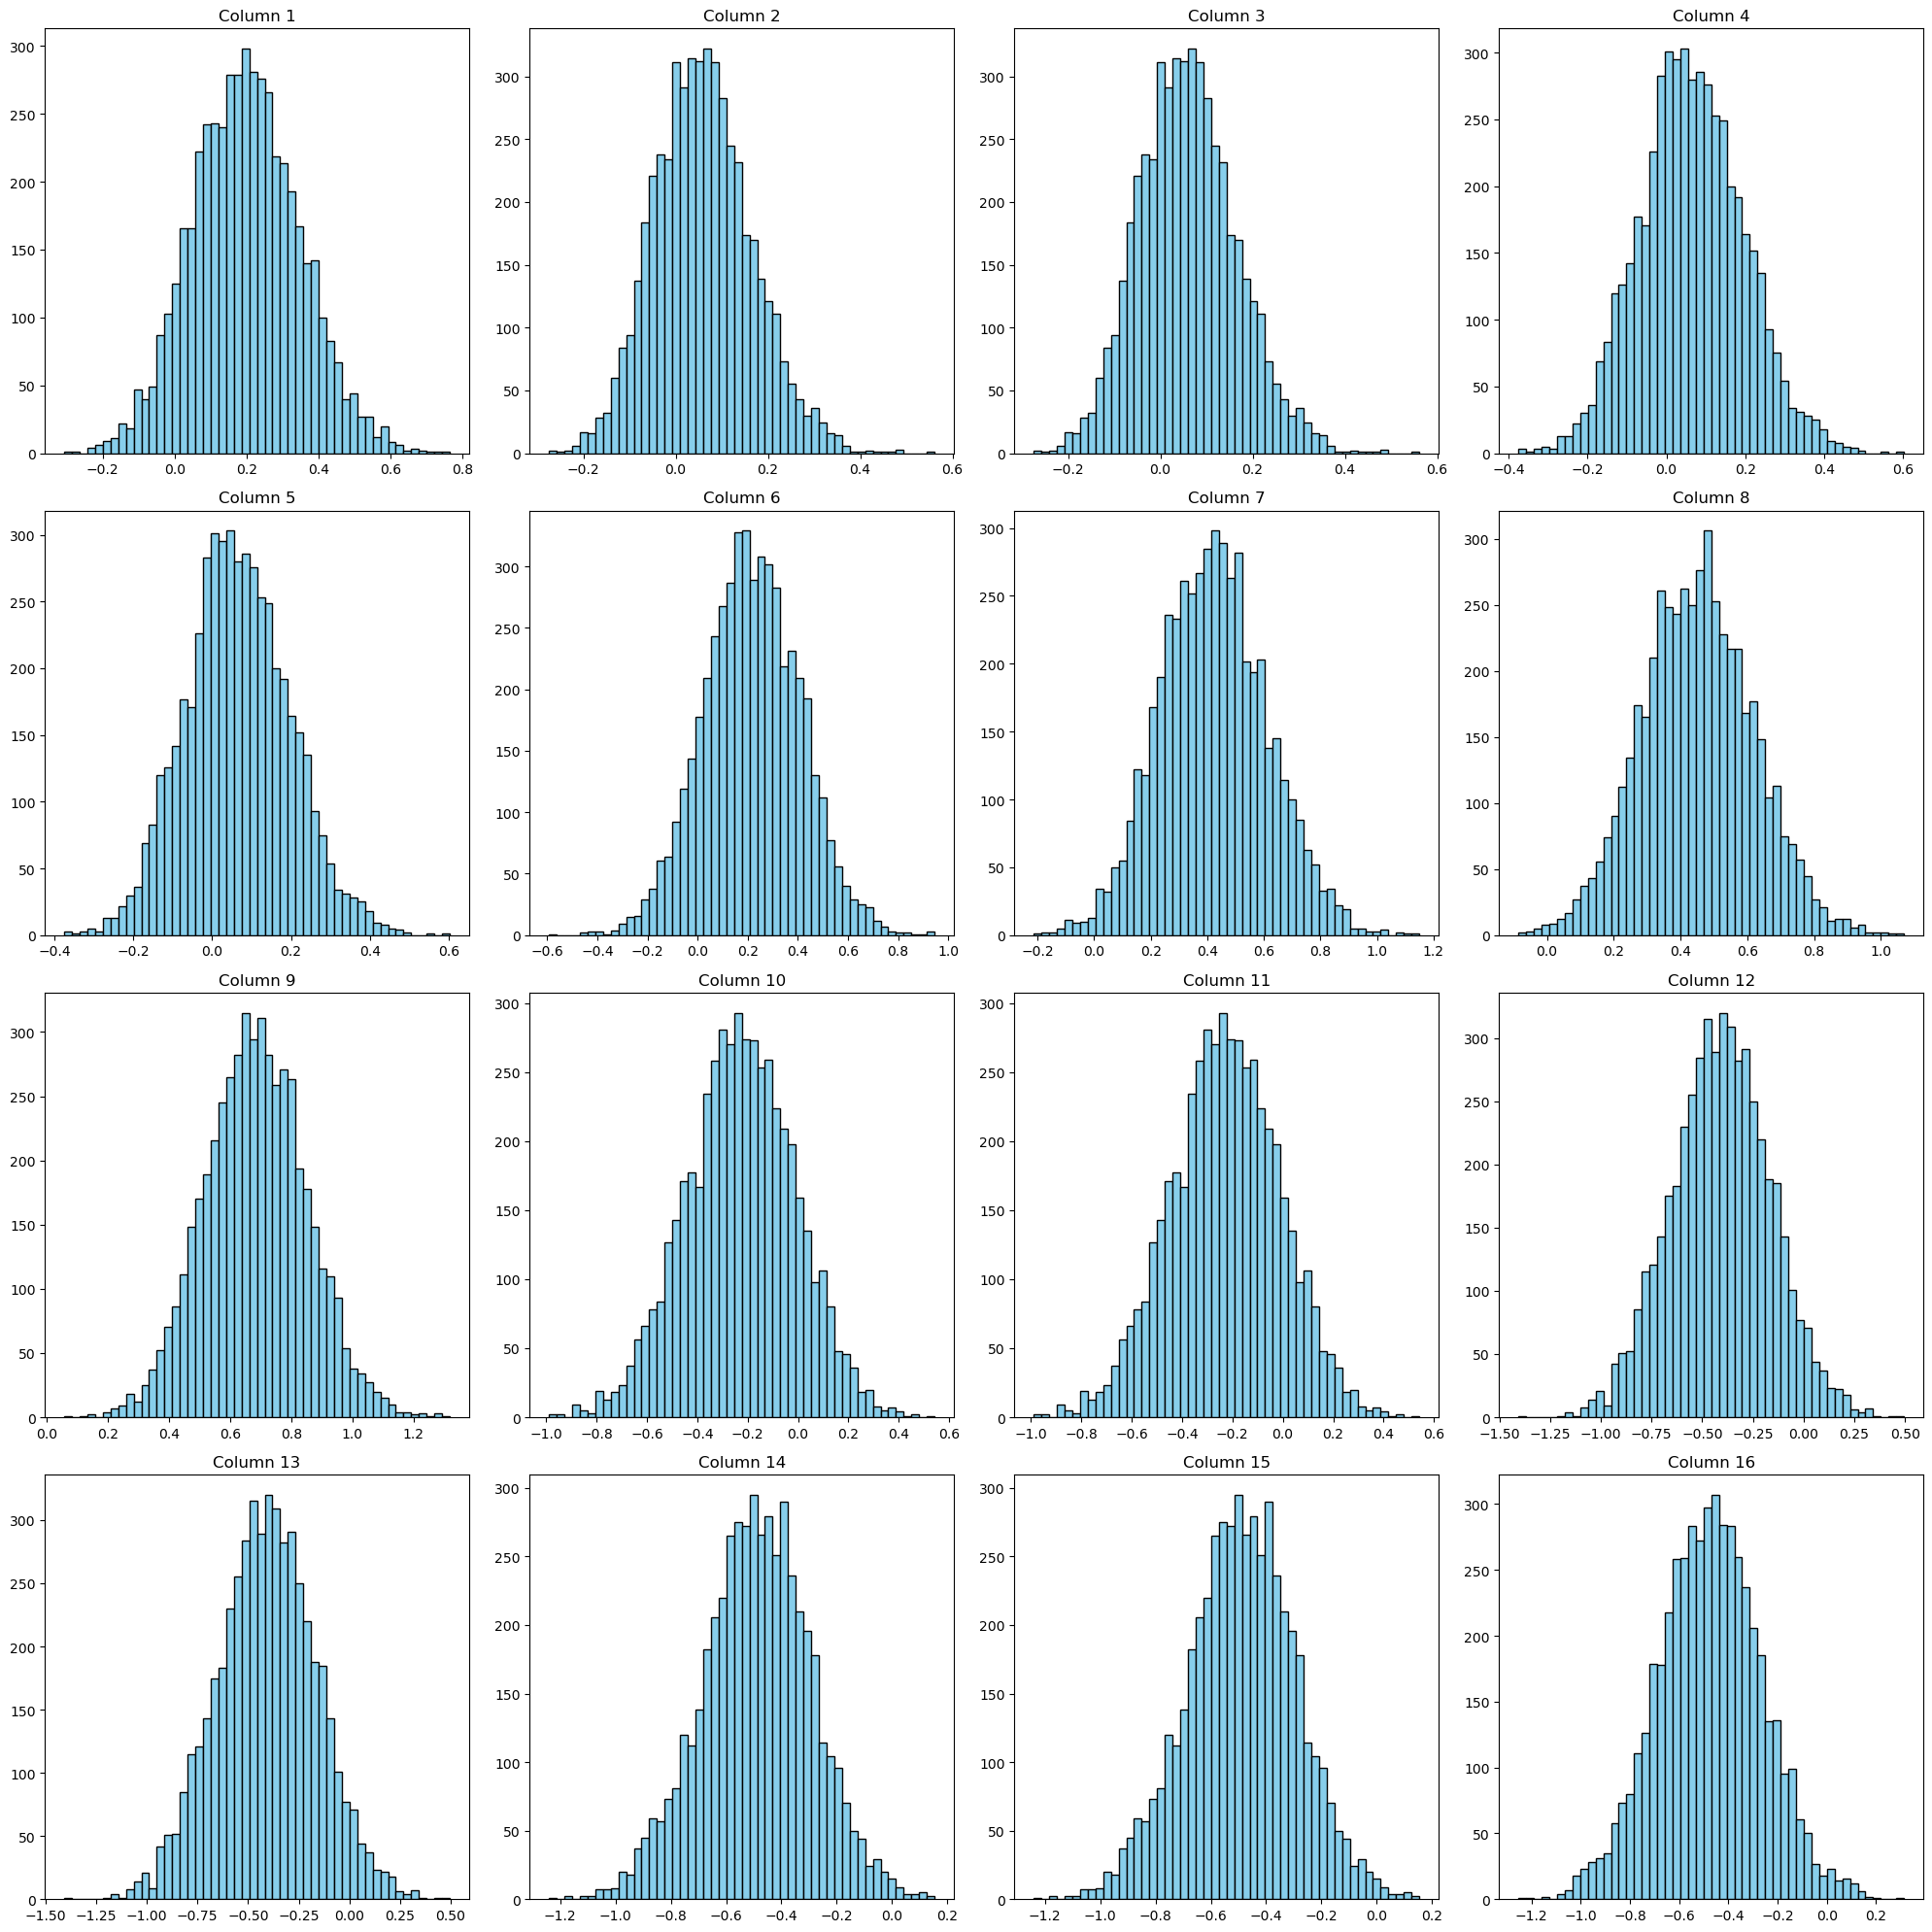

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

for i in range(min(16, Phi.shape[1])):
    plt.subplot(4, 4, i+1)
    plt.hist(Phi[:, i], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Column {i+1}')

plt.tight_layout()
plt.show()


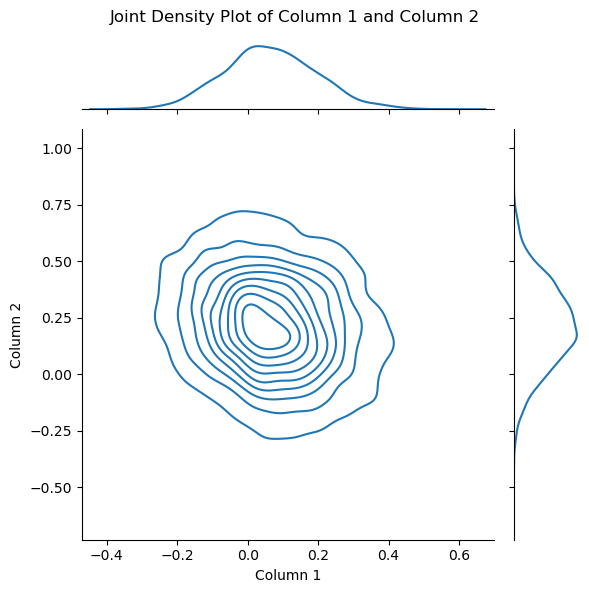

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(x=Phi[:, 3], y=Phi[:, 5], kind='kde')

plt.suptitle('Joint Density Plot of Column 1 and Column 2')
plt.xlabel('Column 1')
plt.ylabel('Column 2')

plt.tight_layout()
plt.show()


In [24]:
data_reconstruct = model_inv_psi(model_psi(data_uniform))

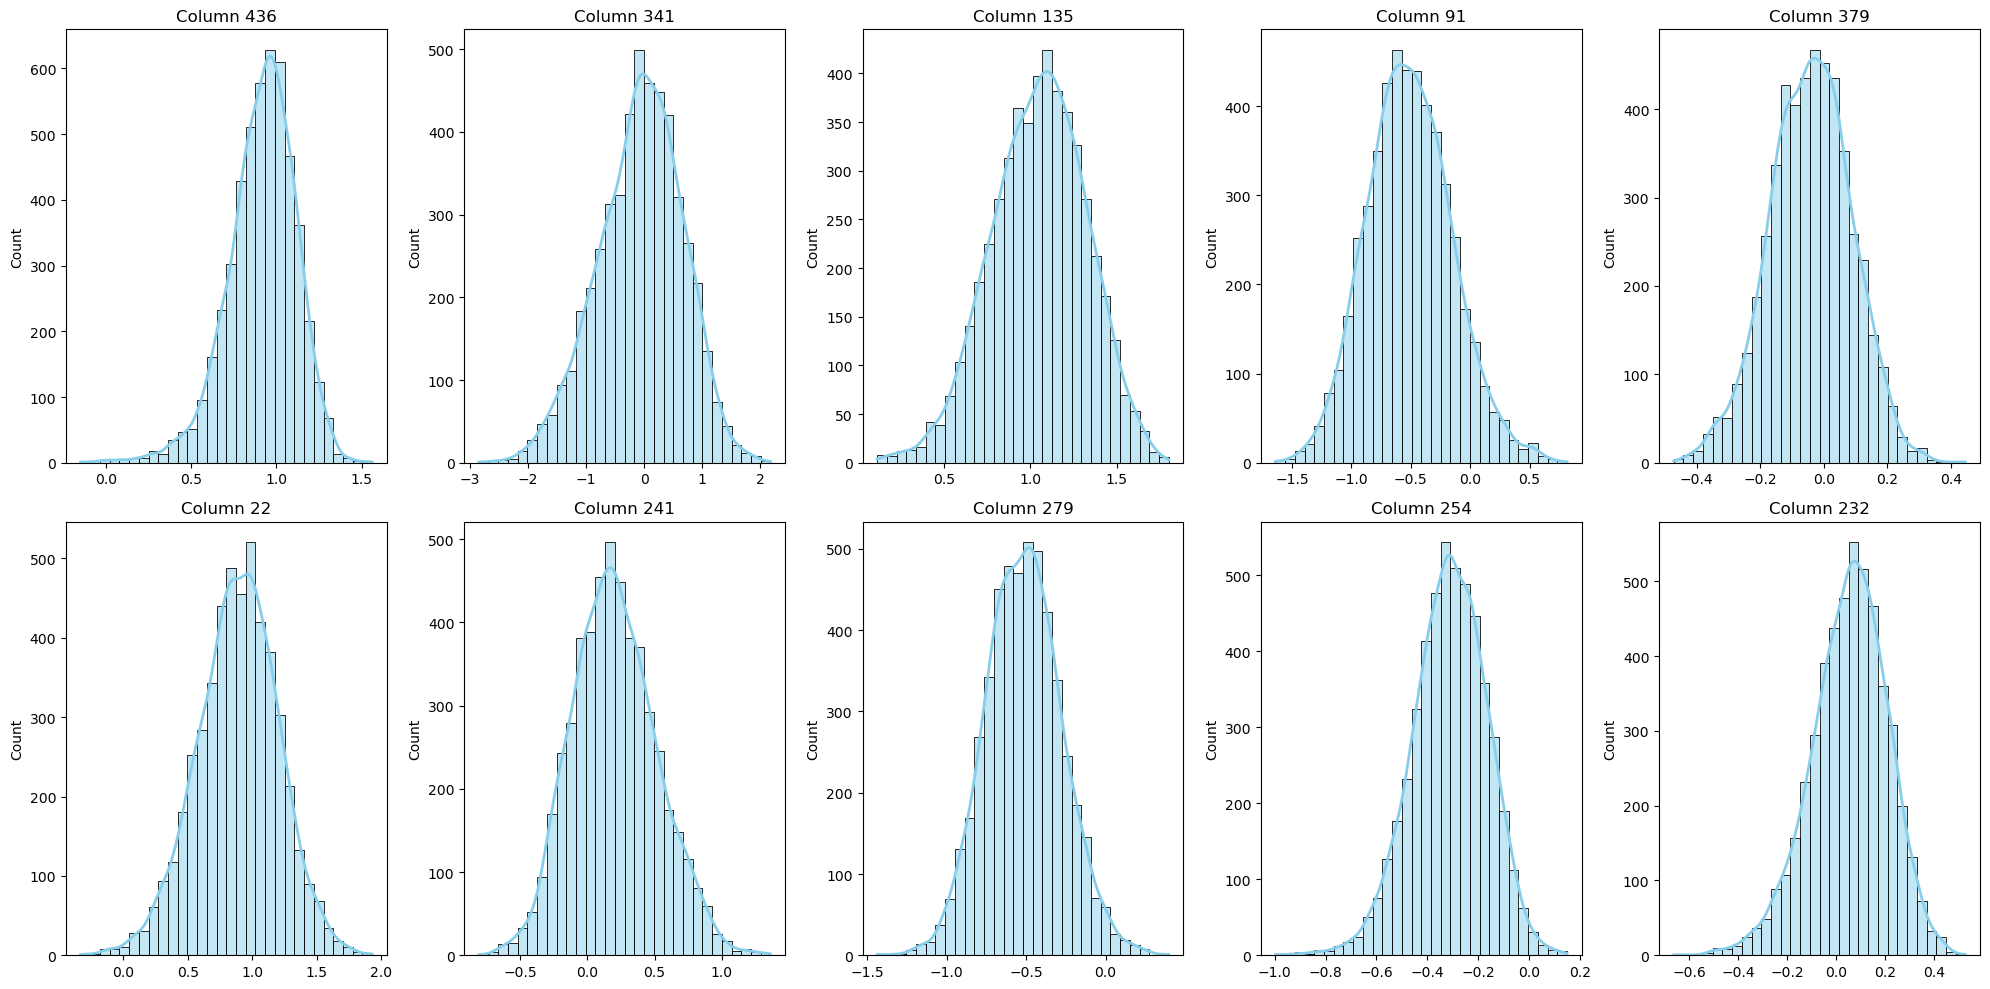

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
data_reconstruct = model_inv_psi(model_psi(data_uniform)).numpy()
columns_to_plot = np.random.choice(data_reconstruct.shape[1], size=10, replace=False)

plt.figure(figsize=(20, 10))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 5, i)
    sns.histplot(data_reconstruct[:, col], kde=True, color='skyblue', bins=30, line_kws={'linewidth': 2})
    plt.title(f'Column {col+1}')

plt.tight_layout()
plt.show()


In [34]:
steps_num = 50
data_psi_x = model_psi(data_uniform)
for step in range(steps_num):
    data_psi_y = data_psi_x @ K
    data_psi_x = data_psi_y
data_predict = model_inv_psi(data_psi_y)

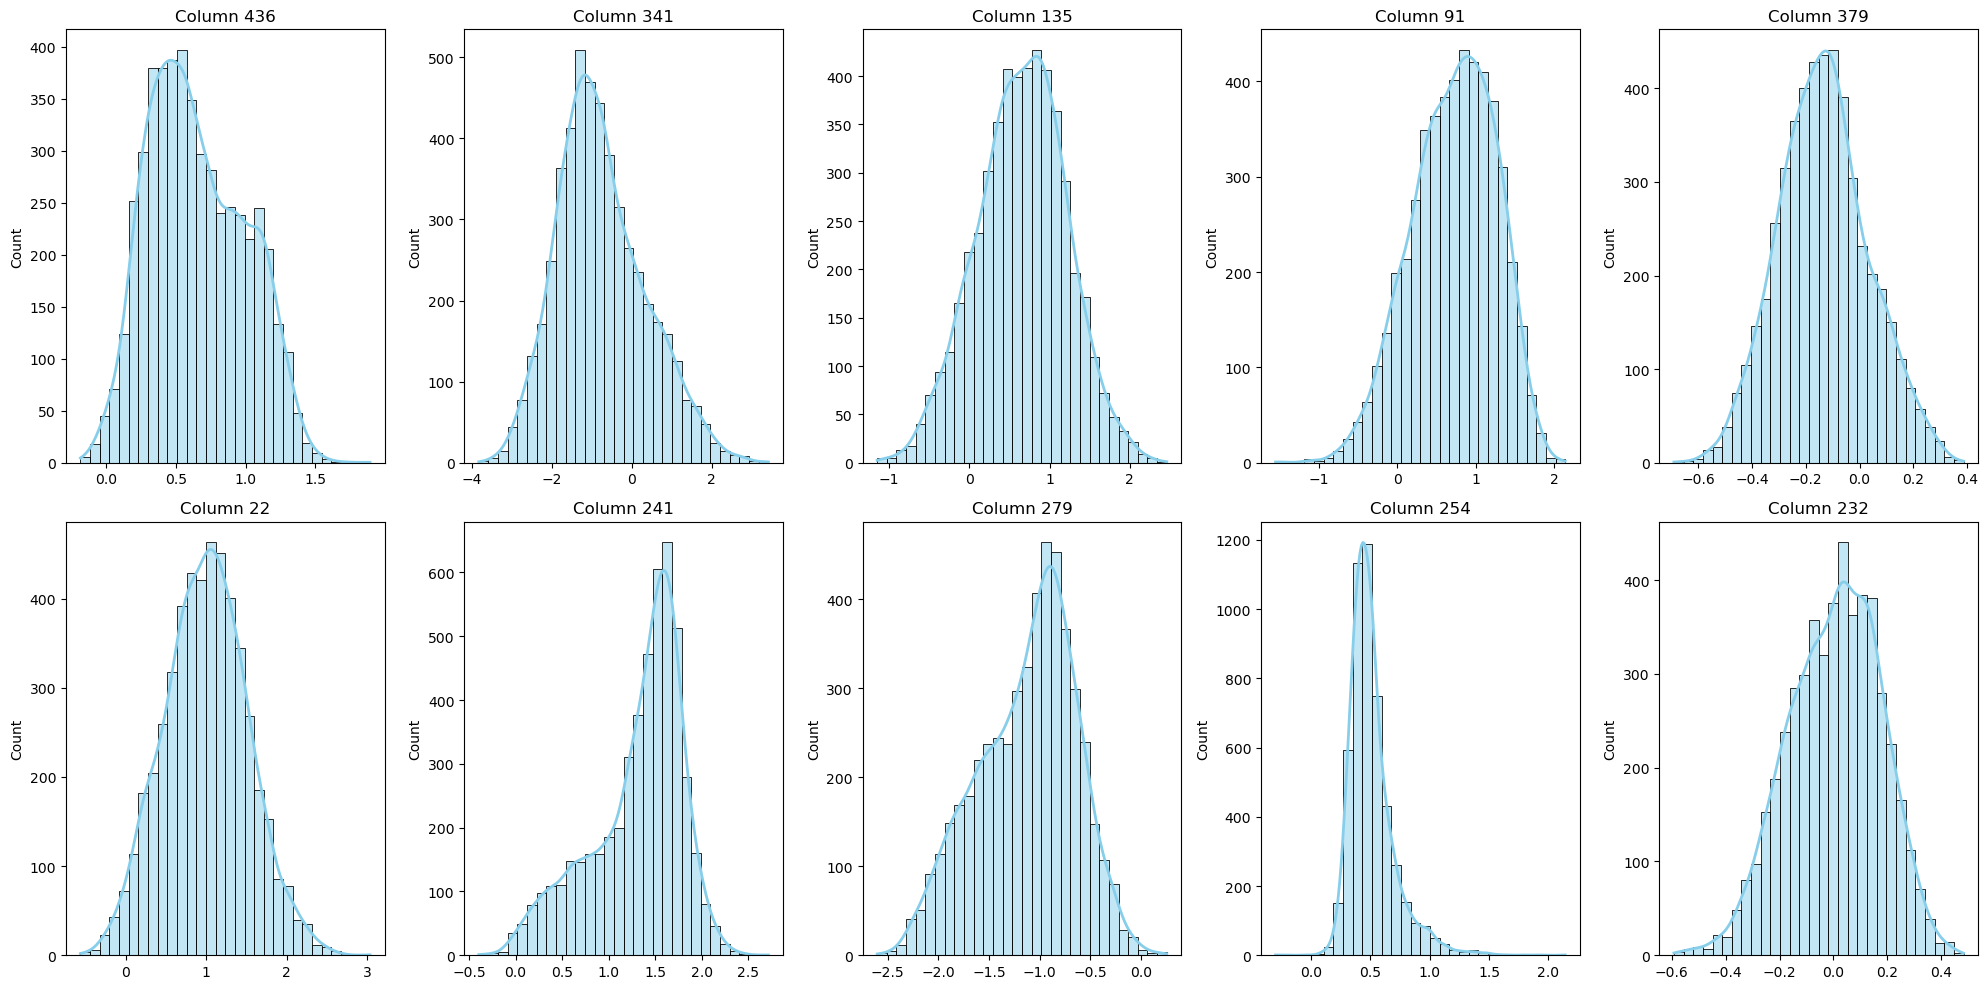

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
columns_to_plot = np.random.choice(data_predict.shape[1], size=10, replace=False)

plt.figure(figsize=(20, 10))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 5, i)
    sns.histplot(data_predict[:, col], kde=True, color='skyblue', bins=30, line_kws={'linewidth': 2})
    plt.title(f'Column {col+1}')

plt.tight_layout()
plt.show()
